## Import Fight Data and Merge with Hometown Data

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

fight_data_file = '../ufcdata/data.csv'
fight_data_file_prep = '../ufcdata/preprocessed_data.csv'
scorecard_data_file = '../scorecard/scorecard.csv'
hometown_data_file = '../elevations/fighters_elevation.csv'

def import_and_merge():
    fight_data = pd.read_csv(fight_data_file)
    hometown_data = pd.read_csv(hometown_data_file)
    
    #Add Blue and Red win columns
    fight_data['B_Winner'] = [1 if x=='Blue' else 0 for x in fight_data['Winner']]
    fight_data['R_Winner'] = [1 if x=='Red' else 0 for x in fight_data['Winner']]
    
    #Drop columns irrelevant to this prediction
    fight_data = fight_data.drop(columns=['Referee', 'no_of_rounds', 'Winner', 'date', 'R_Stance', 'B_Stance'])
    print('Fight Data Stats: ')
    print('Shape: ', fight_data.shape)
    #display(fight_data)
    
    #Separate fight data into individual fighter stats
    blue_fighters = fight_data.loc[:, [col for col in fight_data.columns if re.search('^R_', col)==None]]
    blue_fighters = blue_fighters.rename(columns=lambda x: re.sub('^B_', '', x))
    print('\nBlue fighter Stats: ')
    print('Shape: ', blue_fighters.shape)
    #display(blue_fighters)
    
    red_fighters = fight_data.loc[:, [col for col in fight_data.columns if re.search('^B_', col)==None]]
    red_fighters = red_fighters.rename(columns=lambda x: re.sub('^R_', '', x))
    print('\nRed fighter Stats: ')
    print('Shape: ', red_fighters.shape)
    #display(red_fighters)
    
    #Concatenate blue and red fighter stats
    fighters_data = pd.concat([blue_fighters, red_fighters])
    fighters_data = fighters_data.rename(columns={'total_time_fought(seconds)':'total_time_fought_seconds'})
    print('\nTotal fighter Stats: ')
    print('Shape: ', fighters_data.shape)
    
    # Create df without offence stats
    fighters_no_offence_stats = fighters_data.drop(columns=[col for col in fighters_data.columns if re.search('^avg_', col) != None])
    fighters_no_offence_stats = fighters_data.drop(columns='total_time_fought_seconds')
    
    #Merge with home town data
    hometown_data['merge_key'] = hometown_data['Fighter Name'].apply(lambda x: ' '.join(sorted(str.lower(x).split())))
    hometown_data = hometown_data[~hometown_data.duplicated('merge_key', keep='first')]
    print('\nHometown Stats: ')
    print('Shape: ', hometown_data.shape)
    
    merged_df = fighters_data.copy()
    merged_df['merge_key'] = merged_df['fighter'].apply(lambda x: ' '.join(sorted(str.lower(x).split())))
    merged_df = pd.merge(left=merged_df, right=hometown_data, how='left', left_on='merge_key', right_on='merge_key')
    merged_df = merged_df.drop(columns=['Fighter Name', 'merge_key'])
    merged_df = merged_df.rename(columns={'Location':'hometown'})
    print('\nMerged DF Stats: ')
    print('Shape: ', merged_df.shape)
    #display(merged_df)

    
    return (fighters_no_offence_stats, fighters_data, merged_df)
    


data_no_offence_stats, data, data_w_hometown,  = import_and_merge()

Fight Data Stats: 
Shape:  (5144, 141)

Blue fighter Stats: 
Shape:  (5144, 72)

Red fighter Stats: 
Shape:  (5144, 72)

Total fighter Stats: 
Shape:  (10288, 72)

Hometown Stats: 
Shape:  (1331, 4)

Merged DF Stats: 
Shape:  (10288, 74)



# Data Structuring
- Separate location and home town into city and country
- Categorize weight_class, title_bout, Stance, and locations
- Convert elevation data into numeric data

C:\Users\oyebo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\oyebo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\oyebo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\oyebo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\oyebo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

,KNN,Logistic Regression,SVC,Naive Bayes,Decision Tree,Random Forest
0,0.502388,0.565903,0.554919,0.516714,0.523878,0.544413
1,0.516714,0.565903,0.558739,0.516714,0.504298,0.541070
2,0.523400,0.565903,0.561605,0.516714,0.511939,0.544890
3,0.530086,0.565903,0.561605,0.516714,0.508118,0.546800
4,0.531519,0.565903,0.566858,0.516714,0.506686,0.546323
5,0.527221,0.565903,0.563037,0.516714,0.518147,0.547278
6,0.531519,0.565903,0.564470,0.516714,0.510984,0.542025
7,0.525310,0.565903,0.562082,0.516714,0.514327,0.551576
8,0.517670,0.565903,0.499522,0.516714,0.511939,0.546323
9,0.520057,0.565903,0.495702,0.516714,0.517670,0.547755


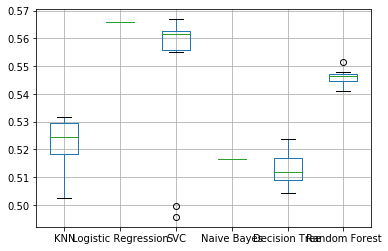

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

def plot_missing_vals(df):
    columns = []
    nans_per_col = []
    

    for col in df.columns:
        num_nans = sum(pd.isnull(df[col]))
        #print('Num of NaNs in col ', col, ': ', num_nans)
        columns.append(col)
        nans_per_col.append(num_nans)
    
    print('Shape: ', df.shape)
    fig = plt.figure(figsize=(30, 13))
    ax = plt.axes()
    ax.bar(columns, nans_per_col)
    plt.xticks(rotation='vertical')
    plt.ylabel('# NaNs')
    plt.title('Number of missing data per feature')
    
def inspect_data(fighter_df):
    # Display missing value numbers in fighter data
    print('\nBefore dropping fightres with no offence/defence stats')
    #plot_missing_vals(fighter_df)
        
    #Remove rows with a lot of missing information
    if 'avg_BODY_att' in fighter_df.columns:
        fighter_df = fighter_df[~pd.isnull(fighter_df['avg_BODY_att'])]
    elif 'total_time_fought_seconds' in fighter_df.columns:
        fighter_df = fighter_df[~pd.isnull(fighter_df['total_time_fought_seconds'])]       
    print('\nAfter dropping fighters with no offence/defemce stats') 
    #plot_missing_vals(fighter_df)
    
    #Fighter age, weight, height, and reach distribution
    hrw_attrs_df = pd.DataFrame(fighter_df[['Height_cms', 'Reach_cms', 'Weight_lbs']])    
    fig = plt.figure(figsize=(30, 13))
    ax = plt.axes()
    hrw_attrs_df.boxplot()
    plt.title('Height, Reach and weight dsitributions')
    plt.ylim([100, 250])
    
    age_df = pd.DataFrame(fighter_df[['age']])   
    fig = plt.figure(figsize=(30, 13))
    ax = plt.axes()
    age_df.boxplot()
    plt.title('Age dsitributions')
       

def clean_data(fighter_df):
    
   #Fill missing values for height, reach, weight, age
    weight_class_means = {}
    weight_classes = np.unique(fighter_df['weight_class'])
    for weight_class in weight_classes:
        weight_class_idx = fighter_df['weight_class'] == weight_class
        
        null_idx = np.logical_and(pd.isnull(fighter_df['Height_cms']), weight_class_idx)
        fighter_df.loc[null_idx, 'Height_cms'] = np.nanmean(fighter_df.loc[weight_class_idx, 'Height_cms'])
        
        null_idx = np.logical_and(pd.isnull(fighter_df['Reach_cms']), weight_class_idx)
        fighter_df.loc[null_idx, 'Reach_cms'] = np.nanmean(fighter_df.loc[weight_class_idx, 'Reach_cms'])
        
        null_idx = np.logical_and(pd.isnull(fighter_df['Weight_lbs']), weight_class_idx)
        fighter_df.loc[null_idx, 'Weight_lbs'] = np.nanmean(fighter_df.loc[weight_class_idx, 'Weight_lbs'])
        
        null_idx = np.logical_and(pd.isnull(fighter_df['age']), weight_class_idx)
        fighter_df.loc[null_idx, 'age'] = np.nanmean(fighter_df.loc[weight_class_idx, 'age'])
    
   #Drop rows with too many missing values
    if 'avg_BODY_att' in fighter_df.columns:
        fighter_df = fighter_df.loc[~pd.isnull(fighter_df['avg_BODY_att']), :]    
        
    return fighter_df

def structure_data(fighter_df):
    
    # Split Locations  and hometowns into city and country
    fighter_df['city'] = [str.lower(location.split(', ')[0]) for location in fighter_df['location']]
    fighter_df['country'] = [str.lower(location.split(', ')[-1]) for location in fighter_df['location']]
    fighter_df = fighter_df.drop(columns='location')
    
    if 'hometown' in fighter_df.columns:
        #First get rid of data with nan hometowns
        fighter_df['hometown_city'] = [str.lower(location.split(', ')[0]) for location in fighter_df['hometown']]
        fighter_df['hometown_country'] = [str.lower(location.split(', ')[-1]) for location in fighter_df['hometown']]
        fighter_df.drop(columns='hometown')
        
    return fighter_df
    

def model_exploration(df, scale, select_top_features):
    #inspect_data(df.copy())
    df = structure_data(df)
    df = clean_data(df)
    df = df.drop(columns=['fighter'])
    dummy_df = pd.get_dummies(df)
    
    labels = dummy_df['Winner']
    features = dummy_df.drop(columns=['Winner'])
    X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=0.75, test_size=0.25, random_state=0, stratify=labels)
    
    #Scale
    if scale:
        scaler = StandardScaler().fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    else:
        X_train_scaled = X_train
        X_test_scaled = X_test
        
    if select_top_features:
        pass
    
    accuracy_df = pd.DataFrame(columns=['KNN', 'Logistic Regression', 'SVC','Naive Bayes', 'Decision Tree', 'Random Forest'])
    precision_df = pd.DataFrame(columns=['KNN', 'Logistic Regression', 'SVC','Naive Bayes', 'Decision Tree', 'Random Forest'])
    recall_df = pd.DataFrame(columns=['KNN', 'Logistic Regression', 'SVC','Naive Bayes', 'Decision Tree', 'Random Forest'])
    f1_df = pd.DataFrame(columns=['KNN', 'Logistic Regression', 'SVC','Naive Bayes', 'Decision Tree', 'Random Forest'])
    
    knn_neighbours = range(5, 55, 5)
    svc_cs = [0.0000005, 0.000001, 0.000005, 0.00001, 0.00005, 0.0001, 0.0005, 0.01, 0.1, 1]
    dtree_minsamples = range(10, 110, 10)
    randomf_estimators = range(50, 550, 50)  
   
    for knn_n, svc_c, dtree_mins, randomf_est, idx in zip(knn_neighbours, svc_cs, dtree_minsamples, randomf_estimators, range(11)):
        knn = KNeighborsClassifier(n_neighbors=knn_n).fit(X_train_scaled, y_train)    
        lr = LogisticRegression(solver='lbfgs', max_iter=100).fit(X_train_scaled, y_train)  
        svc = LinearSVC(max_iter=10000, C=svc_c).fit(X_train_scaled, y_train)
        n_bayes = BernoulliNB().fit(X_train_scaled, y_train)
        decision_tree = DecisionTreeClassifier(min_samples_split=dtree_mins, random_state=0).fit(X_train_scaled, y_train)
        random_forest = RandomForestClassifier(n_estimators=randomf_est, min_samples_split=20, random_state=0).fit(X_train_scaled, y_train)

        accuracy_df.loc[idx] = [knn.score(X_test_scaled, y_test), lr.score(X_test_scaled, y_test), svc.score(X_test_scaled, y_test), n_bayes.score(X_test_scaled, y_test),
                                   decision_tree.score(X_test_scaled, y_test), random_forest.score(X_test_scaled, y_test)]
    display(accuracy_df)
    accuracy_df.boxplot()
    
model_exploration(data_no_offence_stats, False, False)

C:\Users\oyebo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\oyebo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\oyebo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\oyebo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\oyebo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

,KNN,Logistic Regression,SVC,Naive Bayes,Decision Tree,Random Forest
0,0.498090,0.56638,0.564470,0.516714,0.520057,0.540592
1,0.515759,0.56638,0.561605,0.516714,0.506208,0.531519
2,0.513849,0.56638,0.565425,0.516714,0.508118,0.539160
3,0.511939,0.56638,0.567335,0.516714,0.504776,0.540592
4,0.512894,0.56638,0.559694,0.516714,0.507163,0.538682
5,0.511461,0.56638,0.562560,0.516714,0.513849,0.540115
6,0.509074,0.56638,0.568768,0.516714,0.510984,0.542025
7,0.522923,0.56638,0.552531,0.516714,0.513372,0.537727
8,0.527698,0.56638,0.505253,0.516714,0.510984,0.537727
9,0.530564,0.56638,0.503343,0.516714,0.519102,0.540592


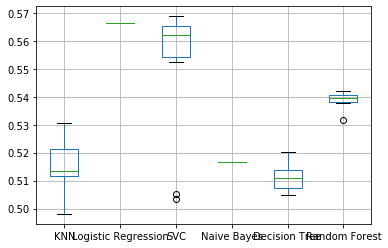

In [4]:
model_exploration(data, False, False)